In [1]:
from IPython.display import display
from notebooks.util.long_memory_utils import *
from liquidity.util.utils import compute_returns, get_agg_features

from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Number of lags for the ACF
ACF_RANGE = 1001

# Lag/window size for Hurst
LAG = 100

## Load raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [5]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,trade_sign,side,lob_action,order_executed,execution_price,execution_size,ask,bid,midprice,ask_volume,bid_volume,price_changing,midprice_change,R1,norm_trade_volume
0,0,2016-01-04 10:30:02.487834868,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
1,1,2016-01-04 10:30:02.594369706,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
2,2,2016-01-04 10:30:02.602151380,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,200.0,100.0,True,-0.095,0.095,0.708122
3,3,2016-01-04 10:30:02.627167275,-1,BID,REMOVE,True,221.27,25,221.36,221.27,221.315,200.0,25.0,True,-0.010,0.010,0.177031
4,4,2016-01-04 10:30:02.895123534,-1,BID,REMOVE,True,221.25,100,221.36,221.25,221.305,100.0,100.0,True,-0.090,0.090,0.708122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757587,757587,2016-12-30 14:57:34.003070849,-1,BID,REMOVE,True,212.66,78,212.71,212.66,212.685,100.0,78.0,True,-0.045,0.045,0.523301
757588,757588,2016-12-30 14:57:49.675498708,1,ASK,REMOVE,True,212.70,100,212.70,212.58,212.640,100.0,3.0,True,0.015,0.015,0.764442
757589,757589,2016-12-30 14:57:50.825570371,1,ASK,REMOVE,True,212.73,118,212.73,212.58,212.655,118.0,3.0,True,-0.005,-0.005,0.902041
757590,757590,2016-12-30 14:58:02.190130229,1,ASK,REMOVE,True,212.72,100,212.72,212.58,212.650,100.0,3.0,True,0.035,0.035,0.764442


# The Long Memory of Orderflow (Trades)

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

## 1. Return magnitudes

In [ ]:
# Return magnitude (volatility)
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

return_magnitudes = {
  'TSLA': abs(tsla_returns),
  'MSFT': abs(msft_returns),
  'AMZN': abs(amzn_returns),
  'NFLX': abs(nflx_returns),
  'EBAY': abs(ebay_returns),
  'APPL': abs(appl_returns)
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

In [ ]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 1.2. Return magnitude ACF

In [ ]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/mo_volatility_linear_acfs.pkl"
volatility_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
print(volatility_linear_acfs.keys())

In [ ]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/mo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
print(volatility_nonlinear_acfs.keys())

In [ ]:
for stock_name in volatility_linear_acfs.keys():
    plot_acf_difference(stock_name, volatility_linear_acfs, volatility_nonlinear_acfs)

### 1.3. Fit power law distribution

In [ ]:
# Load the pre-computed ACFs
volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [ ]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

In [ ]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

In [ ]:
volatility_fit_objects.keys()

### 1.3.Volatility Hurst Exponents

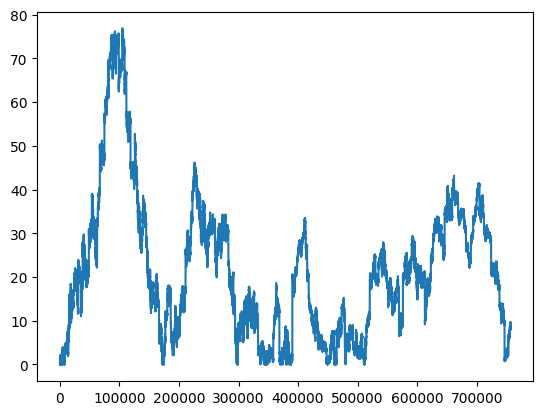

In [11]:
# Compute cumsum of return magnitude (volatility)
tsla_cum_returns = compute_returns(tsla_raw_df)['cumsum_returns']
amzn_cum_returns = compute_returns(msft_raw_df)['cumsum_returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['cumsum_returns']
msft_cum_returns = compute_returns(nflx_raw_df)['cumsum_returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['cumsum_returns']
appl_cum_returns = compute_returns(appl_raw_df)['cumsum_returns']

cumsum_return_magnitudes = {
  'TSLA': abs(tsla_cum_returns),
  'MSFT': abs(amzn_cum_returns),
  'AMZN': abs(nflx_cum_returns),
  'NFLX': abs(msft_cum_returns),
  'EBAY': abs(ebay_cum_returns),
  'APPL': abs(appl_cum_returns)
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
tsla_cumsum_abs_returns = abs(tsla_cum_returns)
x = list(range(1, len(tsla_cumsum_abs_returns)+1))
plt.plot(x, tsla_cumsum_abs_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [7]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0951528...",1,1.0,0.019830,-8164.405554,0.341003,0.999821,0.506448,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0096346...",1,1.0,0.019830,-11785.952502,0.308029,0.999888,0.498441,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1866042...",1,1.0,0.021246,-7624.882911,0.235671,0.999899,0.505193,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0338614...",1,1.0,0.029745,-9214.254425,0.532530,0.999679,0.505422,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0122531...",1,1.0,0.019830,-11927.570405,0.195431,0.999943,0.497863,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0776178...",1,1.0,0.021246,-8524.979689,0.351121,0.999845,0.509733,APPL,volatility


In [8]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5038498463617861


#### Generalized Hurst

In [9]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volaility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volaility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0376913...",16,3.0,0.011577,-9939.744951,0.261057,0.999967,0.582842,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0043299...",37,6.0,0.011940,-14036.054652,0.078898,0.999994,0.550557,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0686098...",44,7.0,0.012066,-9122.557044,0.169755,0.999977,0.575491,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0167242...",9,2.0,0.011461,-10281.632056,0.653504,0.999831,0.544594,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0036676...",9,2.0,0.011461,-12895.232795,0.321400,0.999944,0.581743,EBAY,volatility


In [10]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5445935247768343
Max Generalized Hurst: 0.5828420166525168
Average Generalized Hurst: 0.5683663345055099
Standard_dev Generalized Hurst: 0.01652394735127174


## 2. Orderflow

##  2.1. Signs

In [ ]:
# Signed orderflow
signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'],
  'MSFT': msft_raw_df['trade_sign'],
  'AMZN': amzn_raw_df['trade_sign'],
  'NFLX': nflx_raw_df['trade_sign'],
  'EBAY': ebay_raw_df['trade_sign'],
  'APPL': appl_raw_df['trade_sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in signed_orderflow.items()}

### Stationarity Test

In [ ]:
# ADF test
for stock, data in signed_orderflow.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 2.1. Signs ACF

In [ ]:
# Linear ACF
signs_linear_acf_filename = f"{acf_data_dir}/mo_signs_acfs.pkl"
signs_linear_acfs = compute_acfs(filename=signs_linear_acf_filename, data=signed_orderflow, option='linear')
print(signs_linear_acfs.keys())

In [ ]:
# Nonlinear ACF
signs_nonlinear_acf_filename = f"{acf_data_dir}/mo_signs_nonlinear_acfs.pkl"
signs_nonlinear_acfs = compute_acfs(filename=signs_nonlinear_acf_filename, data=signed_orderflow, option='nonlinear')
print(signs_nonlinear_acfs.keys())

In [ ]:
for stock_name in signs_linear_acfs.keys():
    plot_acf_difference(stock_name, signs_linear_acfs, signs_nonlinear_acfs)

### 2.2. Fit power law distribution

In [ ]:
# Load the pre-computed ACFs
signs_acf_values = {}

for stock, data in signs_nonlinear_acfs.items():
    signs_acf_values[stock] = construct_xy(data, stock)

In [ ]:
# Using signs_nonlinear_acfs
signs_fit_results_list = []
signs_fit_objects = {}  # Dictionary to store fit objects

for stock, data in signs_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[stock] = fit_obj  # Store the fit object

signs_acf_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_acf_fit_results.head())

In [ ]:
signs_fit_objects.keys()

In [ ]:
avg_alpha = signs_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

### 2.3. Signed Orderflow Hurst Exponents

In [ ]:
# Compute cumsum of signed orderflow
cumsum_signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'].cumsum(),
  'MSFT': msft_raw_df['trade_sign'].cumsum(),
  'AMZN': amzn_raw_df['trade_sign'].cumsum(),
  'NFLX': nflx_raw_df['trade_sign'].cumsum(),
  'EBAY': ebay_raw_df['trade_sign'].cumsum(),
  'APPL': appl_raw_df['trade_sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_signed_orderflow.items()}
tsla_cumsum_signs = tsla_raw_df['trade_sign'].cumsum()
x = list(range(1, len(tsla_cumsum_signs)+1))
plt.plot(x, tsla_cumsum_signs)
plt.grid(False)

#### Standard Hurst

In [ ]:
# Standard Hurst
method = 'standard'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_std_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_std_hurst_fit_results.head(10))

In [ ]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = signs_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

#### Generalized Hurst

In [ ]:
# Generalized Hurst
method = 'generalized'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_gen_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_gen_hurst_fit_results.head())

In [ ]:
# Generalized Hurst statistic across stocks
min_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = signs_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

## 3. Size/ Volume

In [ ]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['execution_size'],
               'MSFT': amzn_raw_df['execution_size'],
               'AMZN': nflx_raw_df['execution_size'],
               'NFLX': msft_raw_df['execution_size'],
               'EBAY': ebay_raw_df['execution_size'],
               'APPL': appl_raw_df['execution_size'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [ ]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 3.1. Size/volume ACF

In [ ]:
# Linear ACF
volume_linear_acf_filename = f"{acf_data_dir}/volume_linear_acfs.pkl"
volume_linear_acfs = compute_acfs(filename=volume_linear_acf_filename, data=size_volume, option='linear')
print(volume_linear_acfs.keys())

In [ ]:
# Nonlinear ACF
volume_nonlinear_acf_filename = f"{acf_data_dir}/mo_volume_nonlinear_acfs.pkl"
volume_nonlinear_acfs = compute_acfs(filename=volume_nonlinear_acf_filename, data=size_volume, option='nonlinear')
print(volume_nonlinear_acfs.keys())

In [ ]:
for stock_name in volume_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_linear_acfs, volume_nonlinear_acfs)

### 3.2. Fit power law distribution

In [ ]:
# Load the pre-computed ACFs
volume_acf_values = {}

for stock, data in volume_nonlinear_acfs.items():
    volume_acf_values[stock] = construct_xy(data, stock)

In [ ]:
# Using volume_nonlinear_acfs
volume_fit_results_list = []
volume_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[stock] = fit_obj  # Store the fit object

volume_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_fit_results.head())

In [ ]:
volume_fit_objects.keys()

In [ ]:
avg_alpha = volume_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

In [ ]:
tsla_acf_fit = volume_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Size/ Volume Hurst Exponents

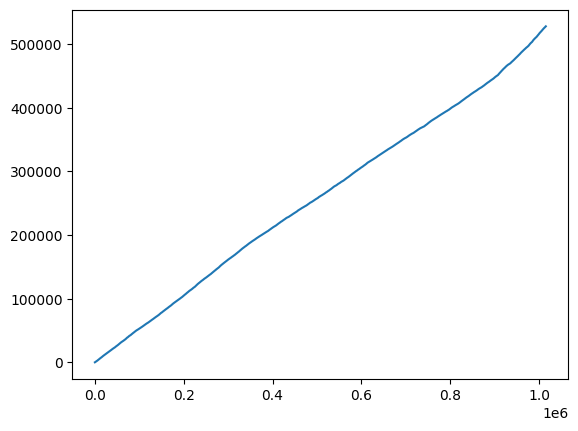

In [52]:
# Compute cumsum of size/volumes
cumsum_size_volume = {
               'TSLA': tsla_raw_df['norm_trade_volume'].cumsum(),
               'MSFT': amzn_raw_df['norm_trade_volume'].cumsum(),
               'AMZN': nflx_raw_df['norm_trade_volume'].cumsum(),
               'NFLX': msft_raw_df['norm_trade_volume'].cumsum(),
               'EBAY': ebay_raw_df['norm_trade_volume'].cumsum(),
               'APPL': appl_raw_df['norm_trade_volume'].cumsum()
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_size_volume.items()}
tsla_cumsum_volume = amzn_raw_df['norm_trade_volume'].cumsum()
x = list(range(1, len(tsla_cumsum_volume)+1))
plt.plot(x, tsla_cumsum_volume)
plt.grid(False)
plt.show()

#### Standard Hurst

In [44]:
# Standard Hurst
method = 'standard'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_size_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_std_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9717211...",1,1.0,0.021246,-3392.127880,1.172769,0.999598,0.630066,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.6894102...",1,1.0,0.019830,-3876.769063,1.132990,0.999729,0.668499,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2485252...",1,1.0,0.019830,-3280.324547,0.811745,0.999569,0.589941,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2305226...",1,1.0,0.021246,-4945.705214,1.537926,0.999507,0.676665,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1484784...",1,1.0,0.021246,-4979.075439,2.141083,0.999317,0.727245,EBAY,volume


In [45]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6568516861655472


In [46]:
print(volume_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'volume'), ('MSFT', 'standard', 'volume'), ('AMZN', 'standard', 'volume'), ('NFLX', 'standard', 'volume'), ('EBAY', 'standard', 'volume'), ('APPL', 'standard', 'volume')])


#### Generalized Hurst

In [47]:
# Generalized Hurst
method = 'generalized'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_size_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method, fitting_method = "Least_squares")
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_gen_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:148: UserWarning: Hurst exponent may not be in a valid range (0,1).
  return H, fit_results
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:148: UserWarning: Hurst exponent may not be in a valid range (0,1).
  return H, fit_results
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:148: UserWarning: Hurst exponent may not be in a valid range (0,1).
  return H, fit_results
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:148: UserWarning: Hurst exponent may not be in a valid range (0,1).
  return H, fit_results


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5656549...",1,1.0,0.011331,-13780.178876,0.000581,1.0,1.000023,TSLA,signed_volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5143783...",1,1.0,0.011331,-13539.728194,0.000651,1.0,1.000026,MSFT,signed_volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5872925...",1,1.0,0.011331,-13280.642586,0.000378,1.0,1.000004,AMZN,signed_volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1864809...",1,1.0,0.011331,-15656.422215,0.000527,1.0,1.000023,NFLX,signed_volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1433532...",1,1.0,0.011331,-15043.052671,0.000456,1.0,0.999990,EBAY,signed_volume


In [48]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9999895937524841
Max Generalized Hurst: 1.0000256050073233
Average Generalized Hurst: 1.0000095280350885
Standard_dev Generalized Hurst: 1.674137214119835e-05


In [49]:
print(volume_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'signed_volume'), ('MSFT', 'generalized', 'signed_volume'), ('AMZN', 'generalized', 'signed_volume'), ('NFLX', 'generalized', 'signed_volume'), ('EBAY', 'generalized', 'signed_volume'), ('APPL', 'generalized', 'signed_volume')])


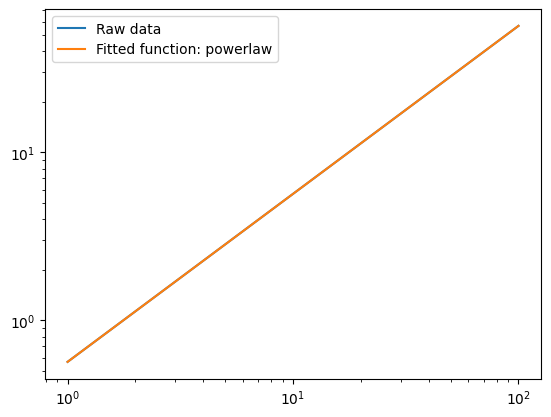

In [50]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volume_fit_objects[('TSLA', 'generalized', 'signed_volume')]
tsla_generalized_fit.powerlaw.plot_fit()

## 4. Signed Ordeflow Imbalance

In [ ]:
# Aggregate orderflow
tsla_aggregate_orderflow = get_agg_features(tsla_raw_df, [LAG], remove_outliers=False)
msft_aggregate_orderflow = get_agg_features(msft_raw_df, [LAG], remove_outliers=False)
amzn_aggregate_orderflow = get_agg_features(amzn_raw_df, [LAG], remove_outliers=False)
nflx_aggregate_orderflow = get_agg_features(nflx_raw_df, [LAG],remove_outliers=False)
ebay_aggregate_orderflow = get_agg_features(ebay_raw_df, [LAG], remove_outliers=False)
appl_aggregate_orderflow = get_agg_features(appl_raw_df, [LAG],remove_outliers=False)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

#### Stationarity Test

In [ ]:
# Sign imbalance ADF test
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

In [ ]:
# Volume imbalance ADF test
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 4.1. Order sign imbalance long memory

In [ ]:
# Linear ACF
sign_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_linear_acfs.pkl"
sign_imbalance_linear_acfs = compute_acfs(filename=sign_imbalance_linear_acf_filename, data=sign_imbalance, option='linear')
print(sign_imbalance_linear_acfs.keys())

In [ ]:
# Nonlinear ACF
sign_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_nonlinear_acfs.pkl"
sign_imbalance_nonlinear_acfs = compute_acfs(filename=sign_imbalance_nonlinear_acf_filename, data=sign_imbalance, option='nonlinear')
print(sign_imbalance_nonlinear_acfs.keys())

In [ ]:
for stock_name in sign_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, sign_imbalance_linear_acfs, sign_imbalance_nonlinear_acfs)

#### 4.1.1. Fit power law distribution

In [ ]:
# Load the pre-computed ACFs
sign_imbalance_acf_values = {}

for stock, data in sign_imbalance_nonlinear_acfs.items():
    sign_imbalance_acf_values[stock] = construct_xy(data, stock)

In [ ]:
# Using signs_imbalance_nonlinear_acfs
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in sign_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

sign_imbalance_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_fit_results.head())

In [ ]:
print(sign_imbalance_fit_objects.keys())

In [ ]:
avg_alpha = sign_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

In [ ]:
tsla_acf_fit = sign_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 4.1.2. Sign Imbalance Hurst Exponents

In [ ]:
# Compute cumsum of order sign imbalance
cumsum_sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'].cumsum(),
  'MSFT': msft_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'].cumsum(),
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'].cumsum(),
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'].cumsum(),
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_sign_imbalance.items()}
tsla_cumsum_sign_imbalance = tsla_aggregate_orderflow['sign_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_sign_imbalance)+1))
plt.plot(x, tsla_cumsum_sign_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [ ]:
# Standard Hurst
method = 'standard'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('sign_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signs_imbalance')] = fit

sign_imbalance_std_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_std_hurst_fit_results.head())

In [ ]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = sign_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

##### Generalized Hurst

In [ ]:
# Generalized Hurst
method = 'generalized'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('signed_imbalance', stock, data, method=method, fitting_method = "Least_squares")
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signed_imbalance')] = fit

sign_imbalance_gen_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_gen_hurst_fit_results.head())

In [ ]:
# Generalized Hurst statistic across stocks
min_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

In [ ]:
print(sign_imbalance_fit_objects.keys())

In [ ]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = sign_imbalance_fit_objects[('TSLA', 'generalized', 'signed_volume')]
tsla_generalized_fit.powerlaw.plot_fit()

### 4.2. Signed Volume imbalance long memory

In [ ]:
# Linear ACF
volume_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_linear_acfs.pkl"
volume_imbalance_linear_acfs = compute_acfs(filename=volume_imbalance_linear_acf_filename, data=volume_imbalance, option='linear')
print(volume_imbalance_linear_acfs.keys())

In [ ]:
# Nonlinear ACF
volume_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_nonlinear_acfs.pkl"
volume_imbalance_nonlinear_acfs = compute_acfs(filename=volume_imbalance_nonlinear_acf_filename, data=volume_imbalance, option='nonlinear')
print(volume_imbalance_nonlinear_acfs.keys())

In [ ]:
for stock_name in volume_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_imbalance_linear_acfs, volume_imbalance_nonlinear_acfs)

#### 4.2.1. Fit power law distribution

In [ ]:
# Load the pre-computed ACFs
volume_imbalance_acf_values = {}

for stock, data in volume_imbalance_nonlinear_acfs.items():
    volume_imbalance_acf_values[stock] = construct_xy(data, stock)

In [ ]:
# Using signs_imbalance_nonlinear_acfs
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

volume_imbalance_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_fit_results.head())

In [ ]:
print(volume_imbalance_fit_objects.keys())

In [ ]:
avg_alpha = volume_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

In [ ]:
tsla_acf_fit = volume_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 4.2.2. Volume Imbalance Hurst Exponents

In [ ]:
# Compute cumsum of order sign imbalance
cumsum_volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'].cumsum(),
 'MSFT': msft_aggregate_orderflow['vol_imbalance'].cumsum(),
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'].cumsum(),
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'].cumsum(),
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'].cumsum(),
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_volume_imbalance.items()}
tsla_cumsum_volume_imbalance = tsla_aggregate_orderflow['vol_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_volume_imbalance)+1))
plt.plot(x, tsla_cumsum_volume_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [ ]:
# Standard Hurst
method = 'standard'
volume_imbalance_fit_results_list = []
voliume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        voliume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_std_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_std_hurst_fit_results.head())

In [ ]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

##### Generalized Hurst

In [ ]:
# Generalized Hurst
method = 'generalized'
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_gen_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_gen_hurst_fit_results.head())

In [ ]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

In [ ]:
print(volume_imbalance_fit_objects.keys())

In [ ]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = volume_imbalance_fit_objects[('TSLA', 'generalized', 'volume_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()